# Tarkastellaan junien kiihtyvyyksiä

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from py_scripts.db_fcns import save_df_to_db, get_df_from_db
from py_scripts.trainlocations import StationsAndDates, TrainLocations

### Valitaan alku- ja loppuasema sekä aikaväli

In [2]:
reset_raw_data = False
do_processing = False
reset_checkpoints = False

choose_route = False

alkuasema = "JY"
loppuasema = "TPE"

alkupvm = "2018-01-01"
loppupvm = "2023-06-30"

asemat_ja_paivat = StationsAndDates(alkuasema, loppuasema, alkupvm, loppupvm)

In [3]:
tl = TrainLocations(asemat_ja_paivat)

### Ladataan raakadata tietokannasta, jos mahdollista

In [4]:
tl.load_raw_data_from_db()

if tl.train_df is not None and tl.timetables is not None and tl.location_df_raw is not None:
    print(f"Trains loaded from DB: {len(tl.train_df)}")
    print(f"Trains with timetables: {len(tl.timetables.groupby(['departureDate', 'trainNumber']).count())}")
    print(f"Trains with locations: {len(tl.location_df_raw.groupby(['departureDate', 'trainNumber']).count())}")

Trains loaded from DB: 19747
Trains with timetables: 19158
Trains with locations: 18684


### Haetaan data Digitrafficin rajapinnoista, jos tarpeen

Alku- ja loppuaseman välillä kulkeneet junat, niiden junatyyppi ja kulkema reitti haetaan `live-trains` -rajapinnasta. Junien toteutuneet aikataulut haetaan `trains`-rajapinnasta ja lopulta sijanti- ja nopeustiedot `train-locations`-rajapinnasta.

In [5]:
tl.find_data(do_limiting=reset_raw_data, force_reset=reset_raw_data)   

if_exists_action = "replace" if reset_raw_data else "fail"
tl.save_raw_data_to_db(if_exists_action=if_exists_action)

Table timetables already exists
Table locations_raw already exists
Table trains already exists


## Katsotaan eri reittivaihtoehtoja

Yleisimmät reitit (junavuorojen lukumäärän mukaan):

In [6]:
routes = tl.get_routes()
routes[routes > 100]

(JY, MUU, JÄS, OV, TPE)                            8100
(JY, JÄS, OV, TPE)                                 6645
(JY, PVI, KEU, HPK, KLO, VLP, JJ, OVK, OV, TPE)    1268
(JY, TPE)                                           769
(JY, JÄS, TV, OV, TPE)                              712
(JY, JÄS, TPE)                                      654
(JY, SAA, TPE)                                      350
(JY, MUU, SAA, JÄS, OV, TPE)                        343
(JY, JÄS, LPR, OV, TPE)                             260
(JY, MUU, JÄS, TPE)                                 211
(JY, SAA, TV, TPE)                                  117
Name: stations, dtype: int64

Reitit ja junavuorojen lukumäärät junatyyppien mukaan.

In [7]:
pd.pivot_table(tl.train_df[tl.train_df["stations"].isin(routes[routes > 100].index)], values="timetableType", index=["stations"], columns=["trainType"], aggfunc=pd.Series.count)

trainType,HDM,IC,LIV,MV,P,S,T,TYO,VET
stations,,,,,,,,,
"(JY, JÄS, LPR, OV, TPE)",NaN,NaN,NaN,NaN,NaN,260.0,NaN,NaN,NaN
"(JY, JÄS, OV, TPE)",NaN,5334.0,NaN,NaN,NaN,1307.0,4.0,NaN,NaN
"(JY, JÄS, TPE)",NaN,NaN,NaN,7.0,1.0,596.0,43.0,NaN,7.0
"(JY, JÄS, TV, OV, TPE)",NaN,602.0,NaN,NaN,NaN,110.0,NaN,NaN,NaN
"(JY, MUU, JÄS, OV, TPE)",NaN,4263.0,NaN,NaN,NaN,3833.0,4.0,NaN,NaN
"(JY, MUU, JÄS, TPE)",NaN,NaN,NaN,1.0,NaN,206.0,3.0,NaN,1.0
"(JY, MUU, SAA, JÄS, OV, TPE)",NaN,341.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN
"(JY, PVI, KEU, HPK, KLO, VLP, JJ, OVK, OV, TPE)",1268.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(JY, SAA, TPE)",NaN,NaN,1.0,4.0,NaN,NaN,343.0,NaN,2.0


## Valitaan reitti

Oletuksena on muutama hyväksi valittu reitti. Jos ei muuten reittiä saa valittua, niin reitiksi valitaan se, jonka junavuorojen lukumäärä jaettuna reitin osavälien määrällä on suurin.

In [8]:
route = None

r_hki_ol = ('HKI', 'PSL', 'TKL', 'TPE', 'SK', 'KOK', 'YV', 'OL')
r_jy_tpe = ('JY', 'JÄS', 'OV', 'TPE')
r_tpe_jy = ('TPE', 'OV', 'JÄS', 'JY')

if r_hki_ol in routes.index:
    route = r_hki_ol
elif r_jy_tpe in routes.index:
    route = r_jy_tpe
elif r_tpe_jy in routes.index:
    route = r_tpe_jy

if choose_route:
    indeksi = input("Valitse indeksi: ")
    # indeksi = "0"

    try:
        indeksi = int(indeksi)
        route = routes.index[indeksi]
    except ValueError:
        route = tuple([s.strip() for s in indeksi.split(",")])

if route is None:
    weighted_counts = routes.reset_index().apply(lambda r: r.iloc[1] / (len(r.iloc[0]) - 1), axis=1)
    route = routes.index[weighted_counts.argmax()]

print(route)

('JY', 'JÄS', 'OV', 'TPE')


## Ladataan prosessoitu data tietokannasta, jos mahdollista

In [9]:
tl.load_checkpoint_data_from_db(route, verbose=True)

## Prosessoidaan data, jos tarpeen

In [10]:
if not tl.checkpoint_data_exists():
    do_processing = True

Jokaisen junavuoron kohdalla yhdistetään pysähdykset aikatauluun merkittyihin pysähdyksiin ja lasketaan nopeusdatan perusteella junan kulkema matka (sekä matkaan kulunut aika). Nämä junien sijaintitiedot ryhmitellään edelleen reitin osavälien mukaan. Siten jokaisen osavälin pituutta voi arvioida kuljettujen matkojen mediaanin avulla (keskiarvokin toimisi, etenkin jos junavuoroja on riittävästi).

In [11]:
if do_processing:
    _ = tl.process_train_locations(route)

In [12]:
if do_processing:
    tl.calculate_best_distance_estimate(method="median", num_of_decimals=-2)

#### Parhaat välimatka-estimaatit

In [13]:
# for dc in tl.interval_dfs:
#     print(f"{dc.get_interval_name()}: \t {dc.distance}")

pd.DataFrame([[idf.get_interval_name(), idf.distance] for idf in tl.interval_dfs], columns=["interval", "distance"])

,interval,distance
0,JY-JÄS,56900.0
1,JÄS-OV,55900.0
2,OV-TPE,41000.0


#### Poistetaan data, jonka antamat etäisyydet poikkeavat liikaa mediaanista

In [14]:
if do_processing:
    _ = tl.filter_data_based_on_distance(percentage=2, min_error=500)

In [15]:
# for idf in tl.interval_dfs:
#     print(f"{idf.get_interval_name()}: \t {len(idf.trains[idf.trains['in_analysis'] == True])}")

pd.DataFrame([[idf.get_interval_name(), len(idf.trains[idf.trains["in_analysis"] == True])] for idf in tl.interval_dfs], columns=["interval", "num_of_trains"])

,interval,num_of_trains
0,JY-JÄS,4265
1,JÄS-OV,5262
2,OV-TPE,3934


## Jaetaan kukin välimatka tasaisin välein oleviin "checkpointeihin" ja analysoidaan dataa niiden avulla

Skaalataan joka junavuoron kulkema matka samaksi (ja skaalataan myös nopeudet vastaavasti). Lisätään checkpointit (oletuksena 100 metrin välein). Tämän jälkeen käytetään nopeusdataa arvioimaan jokaisen junan osalta matkaan kulunut aika ja nopeus checkpointien kohdalla. Lopuksi otetaan tarkasteltavaksi pelkästään checkpointien kohdalla oleva data.

In [16]:
if do_processing:
    tl.focus_on_checkpoints(checkpoint_interval=100)

In [17]:
# if do_processing:
#     tl.save_checkpoint_data_to_db()

Lasketaan junien kiihtyvyydet ja yhdistetään osavälien checkpoint-data koko reitin checkpoint-dataksi.

In [18]:
if_exists_action2 = "replace" if reset_checkpoints else "fail"

if tl.clustering_data is None or reset_checkpoints:
    tl.calculate_accelerations()
    tl.get_checkpoint_data_for_full_route()

tl.save_checkpoint_data_to_db(if_exists_action=if_exists_action2)

Table checkpoint_locations already exists
Table trains_0 already exists
Table locations_0 already exists
Table checkpoint_locations_0 already exists
Table trains_1 already exists
Table locations_1 already exists
Table checkpoint_locations_1 already exists
Table trains_2 already exists
Table locations_2 already exists
Table checkpoint_locations_2 already exists


In [19]:
# tl.calculate_accelerations()

In [20]:
# tl.get_checkpoint_data_for_full_route()

## Klusteroidaan junavuorot kiihtyvyyksien mukaan

Tässä tapauksessa ryhmitellään data 5 klusteriin sekä koko reitillä että osaväleillä.

In [21]:
tl.setup_for_clustering()

In [22]:
tl.run_kmeans_clustering(5, rng=908)

#### Tarkastellaan klustereiden keskipisteitä ja kiihtyvyyksiä klustereissa

Clustering results for interval JY-TPE


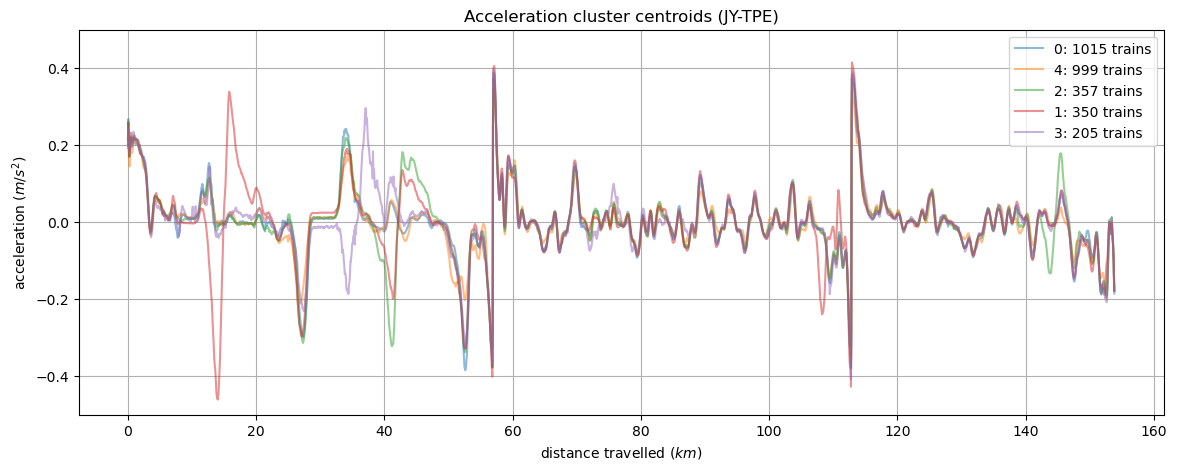

            count  min_abs_accel  max_abs_accel  median_abs_accel  \
cluster_id                                                          
4             999    5366.176677   27915.884740      10584.570147   
0            1015    5659.518070   28309.531608      10618.075060   
3             205    7936.423220   23390.329376      11515.453403   
2             357    7562.607906   19707.871374      11677.607744   
1             350    9057.800887   17947.180988      12183.316158   

            mean_abs_accel  
cluster_id                  
4             10959.285850  
0             11055.127697  
3             11803.166112  
2             11901.787979  
1             12313.665332  

Clustering results for interval JY-JÄS


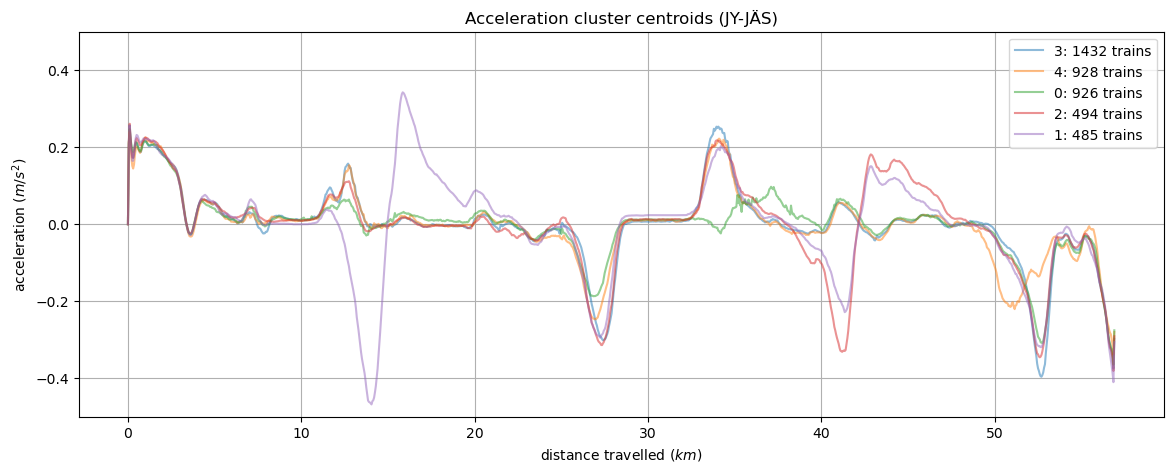

            count  min_abs_accel  max_abs_accel  median_abs_accel  \
cluster_id                                                          
0             926    1401.515856    9611.855387       4308.075253   
3            1432    2367.224882    9619.663022       4281.573300   
4             928    2415.238592    9858.122942       4340.366085   
2             494    3251.156902    8369.547914       5176.222407   
1             485    4215.959404    9439.340986       6270.447311   

            mean_abs_accel  
cluster_id                  
0              4427.856780  
3              4491.308297  
4              4517.739699  
2              5307.718098  
1              6156.949089  

Clustering results for interval JÄS-OV


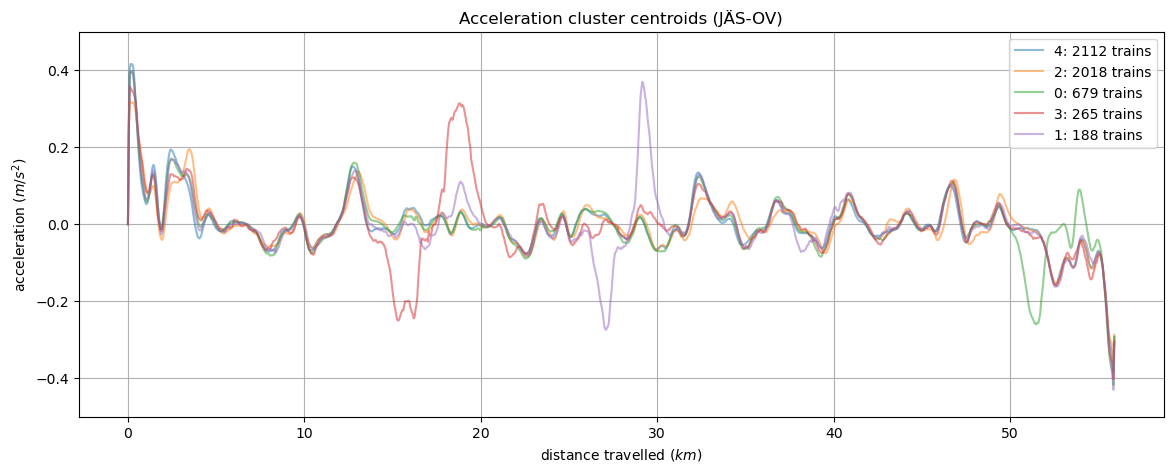

            count  min_abs_accel  max_abs_accel  median_abs_accel  \
cluster_id                                                          
0             679    1908.627491    8642.433579       3432.266554   
4            2112     867.005440   10409.396495       3542.788816   
2            2018     701.402610   10400.375013       3604.177926   
1             188    2494.096363    6907.702105       4327.891667   
3             265    3059.300232    9662.117562       4440.799975   

            mean_abs_accel  
cluster_id                  
0              3577.868460  
4              3680.995233  
2              3798.774015  
1              4433.495184  
3              4561.906164  

Clustering results for interval OV-TPE


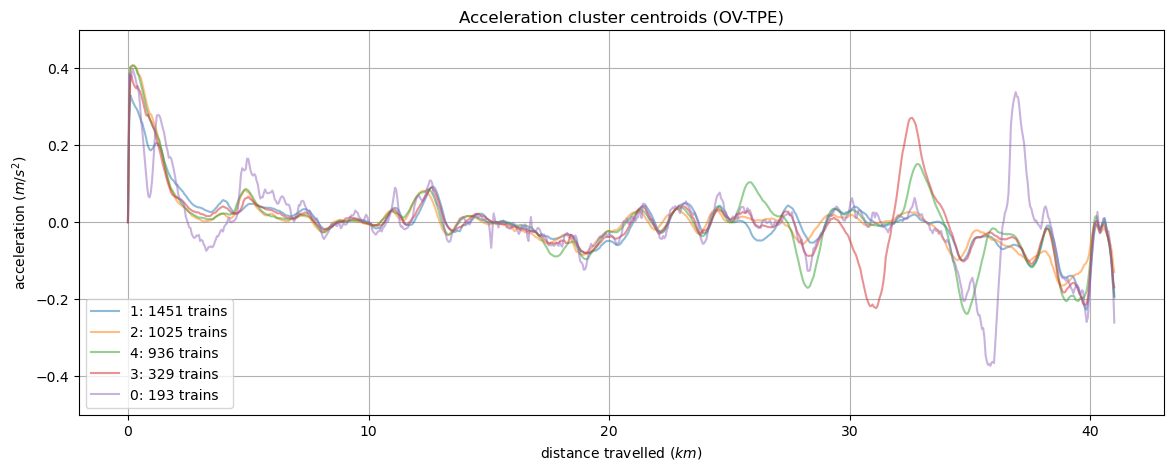

            count  min_abs_accel  max_abs_accel  median_abs_accel  \
cluster_id                                                          
2            1025    1118.371019    7321.082323       2535.226548   
1            1451    1148.495753    8464.757257       2592.814837   
4             936    2061.603406    7313.100741       2875.424424   
3             329    1823.800149    6733.917407       3054.556713   
0             193    2269.529301    9055.215904       4147.674931   

            mean_abs_accel  
cluster_id                  
2              2701.798213  
1              2759.276801  
4              2999.175296  
3              3192.882619  
0              4635.538308  



In [23]:
tl.show_clustering_results()

#### Korreloivatko kiihtyvyyksien suuruudet eri osaväleillä?

In [24]:
print(f"Trains with data everywhere: {len(tl.clustering_data.cluster_df)}")
tl.get_acceleration_correlations()

Trains with data everywhere: 2926


,JY-JÄS,JÄS-OV,OV-TPE
JY-JÄS,1.000000,0.304123,0.364163
JÄS-OV,0.304123,1.000000,0.694109
OV-TPE,0.364163,0.694109,1.000000


In [25]:
tl.get_acceleration_correlations(method="spearman")

,JY-JÄS,JÄS-OV,OV-TPE
JY-JÄS,1.000000,0.237076,0.328767
JÄS-OV,0.237076,1.000000,0.579393
OV-TPE,0.328767,0.579393,1.000000


#### Yritetään tarkastella, ovatko klusterit "samoja" eri osaväleillä

In [26]:
tl.compare_clusters()

JY-TPE vs. JY-JÄS
Accuracy: 0.7570061517429938

              precision    recall  f1-score   support

           0       0.93      0.31      0.46       613
           1       0.95      0.99      0.97       338
           2       0.96      0.99      0.97       349
           3       0.80      0.83      0.81       976
           4       0.54      0.83      0.65       650

    accuracy                           0.76      2926
   macro avg       0.84      0.79      0.77      2926
weighted avg       0.80      0.76      0.74      2926


JY-TPE vs. JÄS-OV
Accuracy: 0.5816814764183186



c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       381
           1       0.00      0.00      0.00       106
           2       0.56      0.67      0.61      1129
           3       0.00      0.00      0.00       149
           4       0.54      0.57      0.56      1161

    accuracy                           0.58      2926
   macro avg       0.38      0.40      0.39      2926
weighted avg       0.54      0.58      0.56      2926


JY-TPE vs. OV-TPE
Accuracy: 0.4613807245386193

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.59      0.54      0.56      1076
           2       0.00      0.00      0.00       772
           3       0.56      0.82      0.67       246
           4       0.36      0.79      0.49       717

    accuracy                           0.46      2926
   macro avg       0.30      0.43      0.34      2926
weighted avg       0.35     

c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metr

JÄS-OV vs. OV-TPE
Accuracy: 0.43369788106630214

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.56      0.58      0.57      1076
           2       0.34      0.52      0.41       772
           3       0.00      0.00      0.00       246
           4       0.38      0.34      0.36       717

    accuracy                           0.43      2926
   macro avg       0.26      0.29      0.27      2926
weighted avg       0.39      0.43      0.41      2926




c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kurui\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
